In [3]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import datetime
import nltk
import string
import re
import os
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

#nltk.download('punkt')
#nltk.download('wordnet')
#nltk.download('stopwords')

#-- Text Preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

#-- Neural Network
import tensorflow as tf
from tensorflow import keras

---

## Preprocessing used in ProjA

In [4]:
start = datetime.datetime.now()

labels = pd.read_fwf("label.txt", header=None)
patents = pd.read_fwf("train.txt", header=None)

finish = datetime.datetime.now()
print("Data has been loaded. Elapsed Time: {} seconds".format((finish-start).total_seconds()))

Data has been loaded. Elapsed Time: 28.744419 seconds


In [5]:
'''
Setting column names for joining
'''
patents = patents.iloc[:,[0,1]]
patents.columns = ['ID', 'Document']
labels.columns = ['ID', 'Label']

In [6]:
pats = patents.join(labels.set_index('ID'), on = 'ID')
pats.head()

,ID,Document,Label
0,20030006121,Passive radio frequency identification system ...,8
1,20030009666,Methods and apparatus for efficient computatio...,0
2,20030014337,"Systems, methods and computer program products...",8
3,20030019942,System and method for electronically readable ...,8
4,20030033242,System and method for automated process of dea...,6


In [7]:
#Removing Punctuation

def no_punctuation(document):
    no_punc = ''.join([character for character in document if character not in string.punctuation])
    return no_punc

start = datetime.datetime.now()
pats.Document = list(map(no_punctuation, pats.Document))
finish = datetime.datetime.now()

print("Punctuation removed from patent! Elapsed Time: {} seconds".format((finish-start).total_seconds()))

Punctuation removed from patent! Elapsed Time: 11.908159 seconds


In [8]:
# Tokenization
def tokenize(document):
    tokened = nltk.word_tokenize(document)
    return tokened

start = datetime.datetime.now()
pats.Document = list(map(tokenize, pats.Document))
finish = datetime.datetime.now()

print("Patents tokenized! Elapsed Time: {} seconds".format((finish-start).total_seconds()))


Patents tokenized! Elapsed Time: 102.275505 seconds


In [9]:
# Stop Word and Numeric Removal 
def no_stops(document):
    stop_words = set(stopwords.words('english'))
    no_stop = [word.lower() for word in document if word not in stop_words]
    no_numeric = [word for word in no_stop if not any(num.isdigit() for num in word)]
    return no_numeric

start = datetime.datetime.now()
pats.Document = list(map(no_stops, pats.Document))
finish = datetime.datetime.now()

print("Stop words removed from patents! Elapsed Time: {} seconds".format((finish-start).total_seconds()))

Stop words removed from patents! Elapsed Time: 18.624167 seconds


In [10]:
# Stemming [state = 0], Lemmatizing [state = 1]

def generate_root(document, state):
    if state == 0:
        stemmer = PorterStemmer()
        stemmed = [stemmer.stem(word.lower()) for word in document] 
        return stemmed
    elif state == 1:
        '''
        Lemmatization has a drawback of needing to specify part of speech. Example:
            For noun, 'building' == 'building',
            For verb, 'building' == 'build'
        '''
        lemmatizer = WordNetLemmatizer()
        lemmatized = [lemmatizer.lemmatize(word.lower(), pos = ['n']) for word in document]
        return lemmatized
    else:
        return document

    
start = datetime.datetime.now()
pats.Document = list(map(lambda x: generate_root(x,0), pats.Document)) #State is specified here
finish = datetime.datetime.now()

print("Root words generated for patents! Elapsed Time: {} seconds".format((finish-start).total_seconds()))

Root words generated for patents! Elapsed Time: 406.214562 seconds


In [11]:
# Rejoining Text After Cleaning

def cleaned_document(document):
    doc = ' '.join(document)
    return doc

start = datetime.datetime.now()
pats.Document = pats.Document.apply(cleaned_document)
finish = datetime.datetime.now()

print("Patents have been rejoined after preprocessing! Elapsed Time: {} seconds".format((finish-start).total_seconds()))

Patents have been rejoined after preprocessing! Elapsed Time: 0.76196 seconds


### Vectorization of Documents

In [12]:
pats.Document[0:7]

0    passiv radio frequenc identif system identifi ...
1    method apparatu effici comput oneway chain cry...
2    system method comput program product perform g...
3    system method electron readabl card power sour...
4    system method autom process deal structur an a...
5    vehicl shop buy system method a complet intern...
6    game cash manag slip method the invent cash ma...
Name: Document, dtype: object

In [13]:
tfidf = TfidfVectorizer(ngram_range = (1,2), analyzer ='word',min_df = .1, max_df=.95)

vectors = tfidf.fit_transform(pats.Document)
vectorDF = pd.DataFrame(data=vectors.toarray())
vectorDF.columns = tfidf.get_feature_names()

vectorDF.head()

,abil,abl,abl access,abl use,abovedescrib,absenc,abstract,acceler,accept,accept payment,...,xml,ye,year,yet,yet anoth,yield,zero,zip,zip code,âˆ
0,0.015772,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0
1,0.000000,0.001681,0.0,0.0,0.019868,0.000000,0.000000,0.0,0.003259,0.0,...,0.0,0.000000,0.004388,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0
2,0.002063,0.001789,0.0,0.0,0.003524,0.000000,0.000000,0.0,0.001734,0.0,...,0.0,0.000000,0.004670,0.000000,0.0,0.0,0.043756,0.0,0.0,0.0
3,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,...,0.0,0.019893,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0
4,0.003374,0.001462,0.0,0.0,0.000000,0.001566,0.002956,0.0,0.007798,0.0,...,0.0,0.000000,0.022909,0.000796,0.0,0.0,0.000000,0.0,0.0,0.0


In [14]:
df = vectorDF.join(labels.Label)
df_features = df.drop('Label', axis = 1)
df_target = df['Label']

### Feature Importance

In [15]:
import matplotlib.pyplot as plt
from sklearn.ensemble import ExtraTreesClassifier
np.random.seed(4)

features = df_features.columns

importance_model = ExtraTreesClassifier()
importance_model.fit(df_features, df_target)

indices = np.argsort(importance_model.feature_importances_)

0.00963116780465739


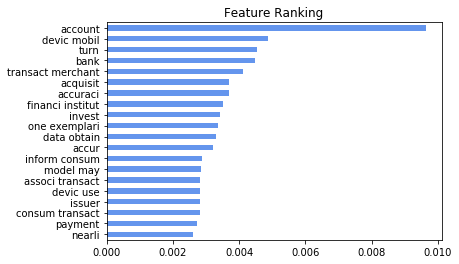

In [16]:
values = pd.Series(importance_model.feature_importances_, index=features)
print(max(values))
values.sort_values(ascending=False).nlargest(20).plot(kind = 'barh', color = 'cornflowerblue', title = 'Feature Ranking').invert_yaxis()

In [17]:
reduced_features = list(values.sort_values(ascending=False).nlargest(500).index)
df_features_reduced = df_features.loc[:,reduced_features]

## Modeling

### Traditional ML Models

In [135]:
#-- Modeling
from sklearn.model_selection import StratifiedKFold
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.svm import NuSVC
from sklearn.ensemble import RandomForestClassifier

In [136]:
# Prepare models
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('DT', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('LiSVM', LinearSVC()))
models.append(('NuSVM', NuSVC(nu= 0.19)))
models.append(('RF', RandomForestClassifier()))

In [143]:
# Evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
for name, model in models:
    kfold = model_selection.StratifiedKFold(n_splits=10, random_state=1)
    cv_results = model_selection.cross_val_score(model, df_features_reduced, df_target, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name) 
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.567421 (0.096192)
LDA: 0.475052 (0.048518)
KNN: 0.580248 (0.075768)
DT: 0.501024 (0.079549)
NB: 0.536612 (0.092766)
LiSVM: 0.626907 (0.103120)
NuSVM: 0.546118 (0.079811)
RF: 0.557186 (0.094251)


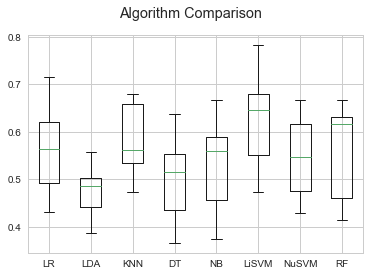

In [144]:
# Boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()
fig.savefig('ModelPerformance_ProjB.png')

As you can see, feature selection stabilized the model accuracies, with most ranging 50% to 60%.

## Neural Networks

In [40]:
import keras
import tensorflow as tf  
print(keras.__version__)
print(tf.__version__) 

2.2.4
1.13.1


-----------------------------------------------------------

# This section was my attempt at preprocessing in Keras. Ignore and continue running at the end of section

In [18]:
tk = keras.preprocessing.text.Tokenizer(num_words=5, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower=True, split=' ', char_level=False, oov_token=None, document_count=0)



In [19]:
from keras.preprocessing.text import text_to_word_sequence
from keras.preprocessing.text import Tokenizer

test = text_to_word_sequence(pats.iloc[0,1])

# tokenize the document
print(len(test)) #Number of words
print(len(set(test))) #Number of unique words

898
305


Using TensorFlow backend.


In [20]:
docs = [x for x in pats.iloc[:,1]]

t = Tokenizer()
t.fit_on_texts(docs)

#print(t.word_counts)
#print(t.document_count)
#print(t.word_index)
#print(t.word_docs)

encoded_docs = t.texts_to_matrix(docs, mode='tfidf')

In [21]:
df_keras = pd.DataFrame(encoded_docs)
df_keras = df_keras.drop([0], axis = 1)
df_keras.columns = columns=t.word_index.keys()
df_keras.head(5)

,may,the,transact,user,system,devic,data,account,payment,use,...,noninfiltr,databasesystem,—establish,fiveday,serviceaccount,embodiment—a,ways—manu,outofbound,coachingwarn,errorswarn
0,0.694283,2.731843,2.150637,0.000000,2.714365,1.219553,2.275771,0.737922,0.000000,2.654810,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,3.424082,3.888924,0.000000,1.253801,1.820640,3.281160,0.000000,0.000000,1.304319,3.572943,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3.592489,2.949076,0.000000,0.000000,3.588434,0.720287,0.711796,2.272387,0.770352,1.807247,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3.559682,3.539693,2.372254,1.767086,2.714365,3.839661,2.275771,1.760899,0.770352,2.287307,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4.578595,4.337419,1.838286,3.124140,3.454549,0.000000,3.156093,2.507381,4.286506,3.691963,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [292]:
from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
train_index, test_index = list(sss.split(df_keras, df_target))[0]

df_train = df_keras.iloc[train_index,:]
df_test = df_keras.iloc[test_index,:]

In [392]:
df_keras.shape

(882, 43212)

In [295]:
df_target.shape

(882,)

# END OF SECTION

---

In [46]:
df_features_reduced = df_features_reduced.values
df_target = pd.get_dummies(df_target).values

In [47]:
from sklearn.model_selection import train_test_split
#X_train, X_test, y_train, y_test = train_test_split(df_keras, df_target, test_size=0.2, random_state=1)
#X_train, X_test, y_train, y_test = train_test_split(df_features_reduced, df_target, test_size=0.2, random_state=1)
X_train, X_test, y_train, y_test = train_test_split(df_features_reduced, df_target, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

In [48]:
X = [X_train, X_val, X_test]

for data in X:
    print(data.shape)

(564, 500)
(141, 500)
(177, 500)


##### Traditional NN

##### Change the folllowing parameters and check the accuracy: 
    1. Vocalbulary_size 
    2. comment_length 
    3. batch_size:  
    4. epochs: 
    5. optimizer: 
    6. Add another lstm layer:  
    7. number of values in each comment 
    8. Add another hidden layer 
    9. Number of nodes in hidden layer 
    10. number of cells in lstm layer 

In [130]:
def bnn(size):
    vocab_size = size

    model = keras.Sequential()
    model.add(keras.layers.Dense(vocab_size, input_dim = size))
    #model.add(keras.layers.Embedding(vocab_size, 64))
    #model.add(keras.layers.GlobalAveragePooling1D())
    #model.add(keras.layers.Bidirectional(tf.keras.layers.LSTM(64)))
    model.add(keras.layers.Dense(32, activation='relu'))
    model.add(keras.layers.Dense(9, activation='softmax'))
    '''
    model.add(keras.layers.Embedding(vocab_size, 64))
    model.add(keras.layers.GlobalAveragePooling1D())
    mokeras.optimizers.Adagrad(lr=0.01, epsilon=None, decay=0.0)del.add(keras.layers.Dense(128, activation='relu'))
    model.add(keras.layers.Dense(128, activation='relu'))
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dense(9, activation='sigmoid'))
    '''
    adagrad = keras.optimizers.Adagrad(lr=0.05, epsilon=None, decay=0.001)
    
    model.compile(optimizer=adagrad,
              loss='binary_crossentropy',
              metrics=['accuracy'])
    
    return model

In [131]:
model_bnn = bnn(X_train.shape[1])

In [135]:
history = model_bnn.fit(X_train,
                        y_train,
                        epochs=20,
                        batch_size=564,
                        validation_data=(X_val, y_val),
                        verbose=1)

Train on 564 samples, validate on 141 samples
Epoch 1/20
564/564 [==============================] - 1s 1ms/step - loss: 0.1211 - acc: 0.9527 - val_loss: 0.2269 - val_acc: 0.9023
Epoch 2/20
564/564 [==============================] - 0s 125us/step - loss: 0.1198 - acc: 0.9521 - val_loss: 0.2061 - val_acc: 0.9157
Epoch 3/20
564/564 [==============================] - 0s 83us/step - loss: 0.1254 - acc: 0.9500 - val_loss: 0.2400 - val_acc: 0.9031
Epoch 4/20
564/564 [==============================] - 0s 71us/step - loss: 0.1188 - acc: 0.9521 - val_loss: 0.2158 - val_acc: 0.9141
Epoch 5/20
564/564 [==============================] - 0s 57us/step - loss: 0.1322 - acc: 0.9486 - val_loss: 0.2279 - val_acc: 0.9078
Epoch 6/20
564/564 [==============================] - 0s 58us/step - loss: 0.1117 - acc: 0.9515 - val_loss: 0.2021 - val_acc: 0.9173
Epoch 7/20
564/564 [==============================] - 0s 73us/step - loss: 0.1089 - acc: 0.9592 - val_loss: 0.2230 - val_acc: 0.9102
Epoch 8/20
564/564 [===

In [146]:
test_eval = model_bnn.evaluate(x=X_test, y= y_test)
print("Test Loss: {}".format(round(test_eval[0],3)))
print("Test Accuracy: {}".format(round(test_eval[1],3)))

177/177 [==============================] - 0s 124us/step
Test Loss: 0.195
Test Accuracy: 0.925


##### RNN

##### CNN

#### Adding Word Embeddings